### Prerequisite Packages

In [1]:
import sys
import os
import math
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [2]:
sys.path.append('../')

from modules.cross_attentionb import CrossAttentionB
from modules.dataloader import load_npy_files
from modules.classifier import DenseLayer, BCELoss, CustomLoss, BCEWithLogits, FocalLoss
from modules.linear_transformation import LinearTransformations

### Model and Hyperparameter Configurations

In [3]:
# Define possible configurations for audio feature directories
audio_feature_paths = {
    'logmel': '../misc/audio_features/logmel',
    'mfcc': '../misc/audio_features/mfcc'
}

# Function to get the audio feature path based on the selected configuration
def get_audio_feature_path(config_name):
    if config_name in audio_feature_paths:
        return audio_feature_paths[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found. Available options: logmel, mfcc.")


In [4]:
# Ensure reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
### Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### Modality Assignment: No Diff for assignments, but the sequence is TAV
set_seed(42)  # Set global seed at the start

### Audio Feature selection: 'logmel' or 'mfcc'
selected_audio_feature= 'logmel'
audio_features_dir = get_audio_feature_path(selected_audio_feature)

#### Data Configuration: 8 16 32 64 128
train_batch_size = 32   # Set the batch size for training data
val_batch_size = 16     # Set the batch size for validation data
test_batch_size= 16     # Set the batch size for testing data

### Filter outliers in video features
lower_bound=35
upper_bound=197

#FIXED CONSTANT
max_pad = 197

### Hyperparameters
threshold = 0.5              # for predictions
learning_rate = 1e-5         # For optimizer
cl_dropout_rate = 0.4        # for FinalClassifier
att_dropout_rate = 0.4       # for MutualCrossAttention
num_epochs = 10              # for model training

### Classifier Configuration
isBCELoss = True                          # !!! SET ACCORDINGLY !!!
criterion = BCELoss()
# criterion = BCEWithLogits()
# criterion = CustomLoss(pos_weight=2.94)
# criterion = FocalLoss(alpha=0.25, gamma=2, pos_weight=0.34)

# !!! Choose Classifier !!! False = Dense Layer, True = Final Classifier
isFinalClassifier = True

#
# ## For cross validation
num_folds = 5          # Set the number of folds for cross-validation
num_epochs_cv = 10     # Set the number of epochs for cross-validation


Device: cuda


### Dataset Class

In [6]:
class MultimodalDataset(Dataset):
    def __init__(self, id_label_df, text_features, audio_features, video_features):
        self.id_label_df = id_label_df
        
        # Convert feature lists to dictionaries for fast lookup
        self.text_features = {os.path.basename(file).split('.')[0]: tensor for file, tensor in text_features}
        self.audio_features = {os.path.basename(file).split('_')[1].split('.')[0]: tensor for file, tensor in audio_features}
        self.video_features = {os.path.basename(file).split('_')[0]: tensor for file, tensor in video_features}

        # List to store missing files
        self.missing_files = []

        # Filter out entries with missing files
        self.valid_files = self._filter_valid_files()

    def _filter_valid_files(self):
        valid_indices = []
        missing_files = []

        for idx in range(len(self.id_label_df)):
            imdbid = self.id_label_df.iloc[idx]['IMDBid']

            # Check if the IMDBid exists in each modality's features
            if imdbid in self.text_features and imdbid in self.audio_features and imdbid in self.video_features:
                valid_indices.append(idx)
            else:
                missing_files.append({'IMDBid': imdbid})

        # Filter id_label_df to only include valid rows
        self.id_label_df = self.id_label_df.iloc[valid_indices].reset_index(drop=True)
        self.missing_files = missing_files
        
        # Update valid_indices to reflect the new indices after resetting
        valid_indices = list(range(len(self.id_label_df)))

        # Return valid indices
        return valid_indices

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Get the original index from the filtered valid files
        original_idx = self.valid_files[idx]
        imdbid = self.id_label_df.iloc[original_idx]['IMDBid']
        label = self.id_label_df.iloc[original_idx]['Label']

        # Retrieve data from the loaded features
        text_data = self.text_features.get(imdbid, torch.zeros((1024,)))
        audio_data = self.audio_features.get(imdbid, torch.zeros((1, 197, 768)))
        video_data = self.video_features.get(imdbid, torch.zeros((95, 768)))
        
        # Define label mapping
        label_map = {'red': 1, 'green': 0} 
        
        # Convert labels to tensor using label_map
        try:
            label_data = torch.tensor([label_map[label]], dtype=torch.float32)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in label_map.")
            raise

        return imdbid, text_data, audio_data, video_data, label_data


In [7]:
def collate_fn(batch):
    # Unpack batch elements
    imdbids, text_data, audio_data, video_data, label_data = zip(*batch)

    # Convert lists to tensors
    text_data = torch.stack(text_data)
    audio_data = torch.stack(audio_data)

    # Padding for video data
    # Determine maximum length of video sequences in the batch
    video_lengths = [v.size(0) for v in video_data]
    max_length = max(video_lengths)

    # Pad video sequences to the maximum length
    video_data_padded = torch.stack([
        F.pad(v, (0, 0, 0, max_length - v.size(0)), "constant", 0)
        for v in video_data
    ])

    # Convert labels to tensor and ensure the shape [batch_size, 1]
    label_data = torch.stack(label_data)  # Convert list of tensors to a single tensor

    return imdbids, text_data, audio_data, video_data_padded, label_data


### Data Loading


In [8]:
def filter_video_features(video_features, lower_bound=lower_bound, upper_bound=upper_bound):
    # Assuming video_features is a list of tuples where the second element is the numpy array
    filtered_video_features = [v for v in video_features if lower_bound <= v[1].shape[0] <= upper_bound]
    return filtered_video_features


In [9]:
# Load the labels DataFrame
id_label_df = pd.read_excel('../misc/MM-Trailer_dataset.xlsx')

# Define the directories
text_features_dir = '../misc/text_features'
audio_features_dir = audio_features_dir
video_features_dir = '../misc/video_features'

# Load the feature vectors from each directory
text_features = load_npy_files(text_features_dir)
audio_features = load_npy_files(audio_features_dir)
video_features = load_npy_files(video_features_dir)

video_features = filter_video_features(video_features)

print(f"Number of text feature vectors loaded: {len(text_features)}")
print(f"Number of audio feature vectors loaded: {len(audio_features)}")
print(f"Number of video feature vectors loaded: {len(video_features)}")

# Drop unnecessary columns
id_label_df = id_label_df.drop(columns=['Movie Title', 'URL'])

full_dataset = MultimodalDataset(id_label_df, text_features, audio_features, video_features)

# perform train-test split on the filtered DataFrame
train_df, val_test_df = train_test_split(
    full_dataset.id_label_df, test_size=0.3, random_state=42, stratify=full_dataset.id_label_df['Label'])

# Further splitting remaining set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Label'])

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

print("Train label distribution:", train_df['Label'].value_counts())
print("Validation label distribution:", val_df['Label'].value_counts())
print("Test label distribution:", test_df['Label'].value_counts())

print("-" * 40)

# create datasets based on these splits
train_dataset = MultimodalDataset(train_df, text_features, audio_features, video_features)
val_dataset = MultimodalDataset(val_df, text_features, audio_features, video_features)
test_dataset = MultimodalDataset(test_df, text_features, audio_features, video_features)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))

# Function to calculate and print the size of each DataLoader
def print_dataloader_sizes(dataloader, name):
    total_samples = len(dataloader.dataset)  # Get the size of the dataset
    num_batches = len(dataloader)  # Get the number of batches
    print(f"{name} DataLoader: Total Samples = {total_samples}, Number of Batches = {num_batches}")

# Print sizes of each DataLoader
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")



Number of text feature vectors loaded: 1353
Number of audio feature vectors loaded: 1353
Number of video feature vectors loaded: 1325
train_df shape: (927, 2)
val_df shape: (199, 2)
test_df shape: (199, 2)
Train label distribution: Label
green    693
red      234
Name: count, dtype: int64
Validation label distribution: Label
green    149
red       50
Name: count, dtype: int64
Test label distribution: Label
green    149
red       50
Name: count, dtype: int64
----------------------------------------
Train DataLoader: Total Samples = 927, Number of Batches = 29
Validation DataLoader: Total Samples = 199, Number of Batches = 13
Test DataLoader: Total Samples = 199, Number of Batches = 13


### Model Class

In [10]:
class MutualCrossAttention(nn.Module):
    def __init__(self, dropout):
        super(MutualCrossAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(768)
        self.device = torch.device("cpu")

    def forward(self, x1, x2):
        # Move x1 and x2 to the correct device
        x1, x2 = x1.to(self.device), x2.to(self.device)

        # Ensure inputs are 3D
        if x1.dim() == 2:
            x1 = x1.unsqueeze(0)
        if x2.dim() == 2:
            x2 = x2.unsqueeze(0)

        # Assign x1 and x2 to query and key
        query = x1
        key = x2
        d = query.shape[-1]

        # Basic attention mechanism formula to get intermediate output A
        scores = torch.bmm(query, key.transpose(1, 2)) / math.sqrt(d)
        output_A = torch.bmm(self.dropout(F.softmax(scores, dim=-1)), x2)

        # Make the summation of the two intermediate outputs
        output = output_A
        
        return output.to(self.device)

In [11]:
def HadamardProduct(tensor1, tensor2):
    # Ensure both tensors have the same shape
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensors must have the same shape for Hadamard product.")
    
    # Compute the Hadamard product
    return tensor1 * tensor2

In [12]:
# Element Add
class EmbracementLayer(nn.Module):
    def __init__(self):
        super(EmbracementLayer, self).__init__()
        self.norm = nn.LayerNorm(768)
        
    def forward(self, video_features, audio_features, text_features):
        combined_features = video_features + audio_features + text_features
        norm_features = self.norm(combined_features)
        return norm_features.to(device)

In [13]:
def PairCrossAttention(modalityAlpha, modalityBeta, dropout=att_dropout_rate):
    mutual_cross_attn = MutualCrossAttention(dropout).to(device)

    return mutual_cross_attn(modalityAlpha, modalityBeta)

### Simul-parallel Functions and Model

In [14]:
class SimultaneousParallel(nn.Module):
    def __init__(self, device):
        super(SimultaneousParallel, self).__init__()
        self.device = device
        self.embrace = EmbracementLayer()
    def forward(self, text_feature, audio_feature, video_feature):

        # One way cross-attention
        text_video = PairCrossAttention(text_feature, video_feature).to(self.device) 
        text_audio = PairCrossAttention(text_feature, audio_feature).to(self.device)
        audio_video = PairCrossAttention(audio_feature, video_feature).to(self.device)
        audio_text = PairCrossAttention(audio_feature, text_feature).to(self.device)
        video_text = PairCrossAttention(video_feature, text_feature).to(self.device)
        video_audio = PairCrossAttention(video_feature, audio_feature).to(self.device)

        # Hadamard products for pairs
        text_combined = HadamardProduct(text_video, text_audio).to(self.device)
        audio_combined = HadamardProduct(audio_video, audio_text).to(self.device)
        video_combined = HadamardProduct(video_text, video_audio).to(self.device)

        # Combine products using element add then normalize
        fused = self.embrace(audio_combined, video_combined, text_combined).to(self.device)

        return fused

In [15]:
def pad_features(features, max_pad=max_pad):
    # Pad or trim the sequence dimension to `max_pad`
    if features.size(1) < max_pad:
        # Pad to the right along the sequence dimension
        features = F.pad(features, (0, 0, 0, max_pad - features.size(1)))
    elif features.size(1) == max_pad:
        pass
    else:
        # Trim if the sequence is longer than `max_pad`
        features = features[:, :max_pad, :]
        print("VIDEO TRIMMED SOMETHING MAY MALI")
    return features

### Classifier

In [16]:
class FinalClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=cl_dropout_rate):
        super(FinalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 3072)  # First fully connected layer
        self.fc2 = nn.Linear(3072, 768)          # Second fully connected layer
        # self.fc3 = nn.Linear(768, 128)          # Third fully connected layer
        # self.fc4 = nn.Linear(128, 64)          # Second fully connected layer

        self.dropout = nn.Dropout(dropout_rate) # Dropout layer
        self.dense = nn.Linear(768, 1)          # Final dense layer for binary classification
        self.relu = nn.ReLU()                    # ReLU activation
        self.sigmoid = nn.Sigmoid()              # Sigmoid activation for final output

    def forward(self, x):
        x = self.fc1(x)                         # First fully connected layer
        x = self.relu(x)                        # Apply ReLU activation

        x = self.fc2(x)                         # second fully connected layer
        x = self.relu(x)                        # Apply ReLU activation
        x = self.dropout(x)                     # Apply dropout
        
        # x = self.fc3(x)                         # third fully connected layer
        # x = self.relu(x)                        # Apply ReLU activation

        # x = self.fc4(x)                         # fourth fully connected layer
        # x = self.relu(x)                        # Apply ReLU activation
        # x = self.dropout(x)                     # Apply dropout
        
        x = self.dense(x)                       # Final dense layer
        if isBCELoss:
            x = self.sigmoid(x)                  # Apply sigmoid activation
        return x                                 # Output probabilities for BCELoss


### Model Training Functions

In [17]:
def train_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    optimizer, 
    device,
    output_dir='results/simulParallel/', 
    output_filename='train_predictions.csv',
):
    # model.train()
    dense_layer.train()
    total_loss = 0.0
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    # List to collect results for CSV
    results = []
    

    for imdbids, text_features, audio_features, video_features, targets in dataloader:
        text_features, audio_features, video_features, targets = (
            text_features.to(device),
            audio_features.to(device),
            video_features.to(device),
            targets.to(device).view(-1)
        )
                
        # Squeeze the audio features to remove the extra dimension
        audio_features = audio_features.squeeze(1).to(device) 
        text_features = text_features.unsqueeze(1).to(device) 

        # Apply linear transformations to match dimensions
        linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)    
        text_features = linear_transform_text(text_features).to(device) 
        
        audio_features = audio_features[:, -1, :].unsqueeze(1).to(device)   # Resulting shape: [batch_size, 1, 768]

        video_features = pad_features(video_features).to(device)   # Shape will be [batch_size, max_pad, 768]

        outputs = model(text_features, audio_features, video_features).to(device)

        outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]

        # Pass the fused features through the dense layer
        predictions = dense_layer(outputs).view(-1)

        # Compute loss
        loss = criterion(predictions, targets)
        total_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # !!!Apply if BCEWithLogits or CustomLoss!!!
        if not isBCELoss:
            predictions = torch.sigmoid(predictions)

        # Apply threshold to get binary predictions
        preds = (predictions >= threshold).float()
        
        # Collect results for each sample
        for i in range(len(imdbids)):
            results.append({
                'IMDBid': imdbids[i],
                'Raw Prediction': predictions[i].item(),
                'Binary Prediction': preds[i].item(),
                'Target': targets[i].item()
            })
        
        # Update metrics for binary classification
        precision_metric.update(preds.long(), targets.long())
        recall_metric.update(preds.long(), targets.long())
        f1_metric.update(preds.long(), targets.long())
        accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    train_precision = precision_metric.compute().item()
    train_recall = recall_metric.compute().item()
    train_f1_score = f1_metric.compute().item()
    train_accuracy = accuracy_metric.compute().item()  # Compute accuracy
    
    train_average_loss = total_loss / len(dataloader)
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)

    return train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score

In [18]:
def evaluate_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/simulParallel/', 
    output_filename='val_predictions.csv',
):
    model.eval()
    dense_layer.eval()
    total_loss = 0.0

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    all_predictions = []
    all_targets = []
    
    # List to collect results for CSV
    results = []
    
    with torch.no_grad():
         for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
        
            # Squeeze the audio features to remove the extra dimension
            audio_features = audio_features.squeeze(1).to(device)
            text_features = text_features.unsqueeze(1).to(device)

            # Apply linear transformations to match dimensions
            linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)   
            text_features = linear_transform_text(text_features).to(device)
            
            audio_features = audio_features[:, -1, :].unsqueeze(1).to(device)  # Resulting shape: [batch_size, 1, 768]
    
            video_features = pad_features(video_features).to(device)  # Shape will be [batch_size, max_pad, 768]
                    
            outputs = model(text_features, audio_features, video_features).to(device)

            outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]

            # Pass the fused features through the dense layer
            predictions = dense_layer(outputs).view(-1)

            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # !!!Apply if BCEWithLogits or CustomLoss!!!
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Collect results for each sample
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics for binary classification
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    val_precision = precision_metric.compute().item()
    val_recall = recall_metric.compute().item()
    val_f1_score = f1_metric.compute().item()
    val_accuracy = accuracy_metric.compute().item() 
    
    # Calculate confusion matrix
    val_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))

    val_average_loss = total_loss / len(dataloader)

    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)
    
    return val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix

In [19]:
def test_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/simulParallel/', 
    output_filename='test_predictions.csv',
):
    model.eval()
    dense_layer.eval()
    total_loss = 0

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 

    all_predictions = []
    all_targets = []
    
    # List to collect results for CSV
    results = []

    with torch.no_grad():
        for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
            
            # Squeeze the audio features to remove the extra dimension
            audio_features = audio_features.squeeze(1).to(device) 
            text_features = text_features.unsqueeze(1).to(device) 

            # Apply linear transformations to match dimensions
            linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)    
            text_features = linear_transform_text(text_features).to(device) 
            
            audio_features = audio_features[:, -1, :].unsqueeze(1).to(device)   # Resulting shape: [batch_size, 1, 768]
    
            video_features = pad_features(video_features).to(device)   # Shape will be [batch_size, max_pad, 768]

            outputs = model(text_features, audio_features, video_features).to(device) 
    
            outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]

            # Pass the fused features through the dense layer
            predictions = dense_layer(outputs).view(-1)
                
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # !!!Apply if BCEWithLogits or CustomLoss!!!
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()
            
            # Collect predictions and targets for the confusion matrix
            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Collect results for each sample
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics for binary classification
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 

     # Compute average precision, recall, F1 score, and accuracy
    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()
    test_f1_score = f1_metric.compute().item()
    test_accuracy = accuracy_metric.compute().item()
    
    # Generate confusion matrix
    test_conf_matrix = confusion_matrix(all_targets, all_predictions)

    test_average_loss = total_loss / len(dataloader)

    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)

    return test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix

In [20]:
def get_optimizer(parameters, lr=learning_rate):
    # Create an optimizer, for example, Adam
    return optim.Adam(parameters, lr=lr)

### Model Training

In [21]:
def plot_confusion_matrix(conf_matrix, class_names=['Negative', 'Positive']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [22]:
# Function to plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(val_losses, label='Validation Loss', color='orange', marker='x')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [23]:
# if __name__ == "__main__":
#     torch.manual_seed(42)

#     # Initialize the SMCA model A
#     model = SimultaneousParallel(device).to(device)  # Dimension for d_out_kq and d_out_v

#     # Determine the output dimensions
#     output_dim = 768

#     # Own DenseLayer or FinalClassifier
#     if isFinalClassifier:
#         dense_layer = FinalClassifier(output_dim * max_pad).to(device) 
#     else:
#         dense_layer = DenseLayer(output_dim * max_pad).to(device)

#     optimizer = get_optimizer(list(dense_layer.parameters()), learning_rate)

#     # Lists to store the training and validation losses
#     train_losses = []
#     val_losses = []
    
#     print("Number of Epochs:", num_epochs)
#     print("learning rate:", learning_rate)


#     for epoch in range(num_epochs):
#         print("-" * 40)
#         print(f"Epoch {epoch + 1}/{num_epochs}")

#         # Ensure you have a dataloader that yields inputs and targets
#         train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device)
#         train_losses.append(train_average_loss)  # Store training loss
        
#         print("-" * 20, "Train", "-" * 20)
#         print(f"Train Accuracy: {train_accuracy:.4f}")
#         print(f"Train Precision: {train_precision:.4f}")
#         print(f"Train Recall: {train_recall:.4f}")
#         print(f"Train F1 Score: {train_f1_score:.4f}")
#         print(f"Train Loss: {train_average_loss:.4f}")
        
#         for name, param in model.named_parameters():
#             if param.grad is None:
#                 print("After train: model:", "No gradient for:", name)
        
#         for name, param in dense_layer.named_parameters():
#             if param.grad is None:
#                 print("After train: classifier:", "No gradient for:", name)

#         # Validate step
#         val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device)
#         val_losses.append(val_average_loss)  # Store validation loss
        
#         print("-" * 20, "Eval", "-" * 20)
#         print(f"Eval Accuracy: {val_accuracy:.4f}")
#         print(f"Eval Precision: {val_precision:.4f}")
#         print(f"Eval Recall: {val_recall:.4f}")
#         print(f"Eval F1 Score: {val_f1_score:.4f}")
#         print(f"Eval Loss: {val_average_loss:.4f}")
        
#     # Testing the model
#     print("-" * 40)
#     print("Testing the model on the test set...")
#     test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix = test_model(model=model, dense_layer=dense_layer, dataloader=test_dataloader, criterion=criterion, device=device)
    
#     print("-" * 20, "Test", "-" * 20)
#     print(f"Test Accuracy: {test_accuracy:.4f}")
#     print(f"Test Precision: {test_precision:.4f}")
#     print(f"Test Recall: {test_recall:.4f}")
#     print(f"Test F1 Score: {test_f1_score:.4f}")
#     print(f"Test Loss: {test_average_loss:.4f}")
    
#     # Summary of metrics
#     metrics_summary = {
#         "Train Accuracy": [train_accuracy],
#         "Validation Accuracy": [val_accuracy],
#         "Test Accuracy": [test_accuracy],
#         "Train Precision": [train_precision],
#         "Validation Precision": [val_precision],
#         "Test Precision": [test_precision],
#         "Train Recall": [train_recall],
#         "Validation Recall": [val_recall],
#         "Test Recall": [test_recall],
#         "Train F1 Score": [train_f1_score],
#         "Validation F1 Score": [val_f1_score],
#         "Test F1 Score": [test_f1_score],
#         "Train Loss": [train_average_loss],
#         "Validation Loss": [val_average_loss],
#         "Test Loss": [test_average_loss]
#     }
    
#     # Create DataFrame
#     metrics_df = pd.DataFrame(metrics_summary)
    

### Results Monitoring

In [24]:
# plot_losses(train_losses, val_losses)

In [25]:
# plot_confusion_matrix(test_conf_matrix)

In [26]:
# Display the table
# metrics_df

In [27]:
# # Print sizes of each DataLoader (FOR CHECKING)
# print_dataloader_sizes(train_dataloader, "Train")
# print_dataloader_sizes(val_dataloader, "Validation")
# print_dataloader_sizes(test_dataloader, "Test")


### Cross-Validation

In [28]:
def plot_average_loss_curves(train_losses_folds, val_losses_folds):
    # Transpose folds to calculate averages per epoch
    num_epochs = len(train_losses_folds[0])
    avg_train_losses = [np.mean([fold[epoch] for fold in train_losses_folds]) for epoch in range(num_epochs)]
    avg_val_losses = [np.mean([fold[epoch] for fold in val_losses_folds]) for epoch in range(num_epochs)]

    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_train_losses, label='Average Training Loss', color='blue', marker='o')
    plt.plot(epochs, avg_val_losses, label='Average Validation Loss', color='orange', marker='o')
    
    plt.title('Average Training and Validation Loss Across Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [29]:
def print_cv_dataloader(dataloader, name="Dataloader"):
    total_samples = len(dataloader.sampler)
    num_batches = len(dataloader)
    print(f"{name}: Total Samples = {total_samples}, Number of Batches = {num_batches}")

In [30]:
def cross_validate_model(
    dataset, 
    model_class, 
    dense_layer_class, 
    num_folds, 
    num_epochs, 
    output_dim,
    criterion,
    learning_rate,
    train_batch_size,
    val_batch_size,
    output_file,
    device=None
):
    # Set device configuration
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    
    set_seed(42)  # Set global seed at the start
    
    # Initialize the KFold splitter
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # lists to store metrics for each fold
    fold_losses = []
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    
    # Lists to store metrics and losses for each fold
    train_losses_folds = []  # List of lists: train_losses_folds[fold][epoch]
    val_losses_folds = []    # List of lists: val_losses_folds[fold][epoch]
    
    print("Number of Epochs:", num_epochs)
    print("learning rate:", learning_rate)
    
    # Perform K-Fold Cross-Validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print("-" * 60)
        print(f"------------------------- Fold {fold + 1 }/{num_folds} -------------------------")
        
        # Create data loaders for the train and validation sets
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=train_batch_size, sampler=train_sampler, collate_fn=collate_fn)
        val_dataloader = torch.utils.data.DataLoader(dataset, batch_size=val_batch_size, sampler=val_sampler, collate_fn=collate_fn)
        
        print_cv_dataloader(train_dataloader, "Train DataLoader")
        print_cv_dataloader(val_dataloader, "Validation DataLoader")
        
        # Initialize the model, dense layer, criterion, and optimizer for each fold
        model = model_class(device).to(device)
        
        dense_layer = dense_layer_class(output_dim * max_pad).to(device)
        criterion = criterion.to(device)
        optimizer = get_optimizer(list(dense_layer.parameters()), learning_rate)

        # Initialize lists to track losses for this fold
        train_losses = []
        val_losses = []
        
        # Use tqdm for progress bar
        epoch_progress = tqdm(range(num_epochs), desc=f"Fold {fold + 1}/{num_folds} Training", leave=True)


        # Training loop for each fold
        for epoch in epoch_progress:
            print(f"------------------------- Epoch {epoch + 1}/{num_epochs} -------------------------")
            
            # Train and evaluate the model on the training and validation sets
            train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device)
            val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device)
            
            # Track losses for this fold and epoch
            train_losses.append(train_average_loss)
            val_losses.append(val_average_loss)
            
            print(f"\nTrain Accuracy: {train_accuracy:.4f}")
            print(f"Train Precision: {train_precision:.4f}")
            print(f"Train Recall: {train_recall:.4f}")
            print(f"Train F1 Score: {train_f1_score:.4f}")
            print(f"Train Loss: {train_average_loss:.4f}")
            
            print(f"\nEval Accuracy: {val_accuracy:.4f}")
            print(f"Eval Precision: {val_precision:.4f}")   
            print(f"Eval Recall: {val_recall:.4f}")
            print(f"Eval F1 Score: {val_f1_score:.4f}")
            print(f"Eval Loss: {val_average_loss:.4f}")

            
            # Update tqdm progress bar description
            epoch_progress.set_postfix({
                "Train Loss": f"{train_average_loss:.4f}",
                "Val Loss": f"{val_average_loss:.4f}",
                "Train F1": f"{train_f1_score:.4f}",
                "Val F1": f"{val_f1_score:.4f}",
            })
        
        # Store losses for the fold
        train_losses_folds.append(train_losses)
        val_losses_folds.append(val_losses)
           
        # Store the validation metrics for this fold
        fold_losses.append(val_average_loss)
        fold_accuracies.append(val_accuracy)
        fold_precisions.append(val_precision)
        fold_recalls.append(val_recall)
        fold_f1_scores.append(val_f1_score)

    # Calculate the average metrics across all folds
    avg_loss = np.mean(fold_losses)
    avg_accuracy = np.mean(fold_accuracies)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_f1_score = np.mean(fold_f1_scores)

    print("-" * 50)
    print("\nK-Fold Cross-Validation Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1_score:.4f}")

    # Plot average loss curves across folds
    plot_average_loss_curves(train_losses_folds, val_losses_folds)

    results_dict = {"Metrics": ["Loss", "Accuracy", "Precision", "Recall", "F1 Score"]}
    for i in range(num_folds):
        results_dict[f"Fold {i + 1}"] = [fold_losses[i], fold_accuracies[i], fold_precisions[i], fold_recalls[i], fold_f1_scores[i]]
    results_dict["Average"] = [avg_loss, avg_accuracy, avg_precision, avg_recall, avg_f1_score]

    # Create DataFrame
    results_df = pd.DataFrame(results_dict)
    
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)  
        
    # Save results to .csv
    results_df.to_csv(output_file, index=False)
    
    return results_df

Device: cuda
Number of Epochs: 10
learning rate: 1e-05
------------------------------------------------------------
------------------------- Fold 1/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17


Fold 1/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 1/5 Training:  10%|█         | 1/10 [03:07<28:11, 187.91s/it, Train Loss=0.5995, Val Loss=0.5925, Train F1=0.1837, Val F1=0.1176]


Train Accuracy: 0.7066
Train Precision: 0.3017
Train Recall: 0.1321
Train F1 Score: 0.1837
Train Loss: 0.5995

Eval Accuracy: 0.7170
Eval Precision: 0.3125
Eval Recall: 0.0725
Eval F1 Score: 0.1176
Eval Loss: 0.5925
------------------------- Epoch 2/10 -------------------------


Fold 1/5 Training:  20%|██        | 2/10 [06:05<24:16, 182.07s/it, Train Loss=0.5401, Val Loss=0.5374, Train F1=0.1457, Val F1=0.2093]


Train Accuracy: 0.7566
Train Precision: 0.5946
Train Recall: 0.0830
Train F1 Score: 0.1457
Train Loss: 0.5401

Eval Accuracy: 0.7434
Eval Precision: 0.5294
Eval Recall: 0.1304
Eval F1 Score: 0.2093
Eval Loss: 0.5374
------------------------- Epoch 3/10 -------------------------


Fold 1/5 Training:  30%|███       | 3/10 [08:59<20:46, 178.12s/it, Train Loss=0.5196, Val Loss=0.5772, Train F1=0.2569, Val F1=0.0941]


Train Accuracy: 0.7708
Train Precision: 0.6774
Train Recall: 0.1585
Train F1 Score: 0.2569
Train Loss: 0.5196

Eval Accuracy: 0.7094
Eval Precision: 0.2500
Eval Recall: 0.0580
Eval F1 Score: 0.0941
Eval Loss: 0.5772
------------------------- Epoch 4/10 -------------------------


Fold 1/5 Training:  40%|████      | 4/10 [11:50<17:32, 175.46s/it, Train Loss=0.5106, Val Loss=0.5221, Train F1=0.3284, Val F1=0.3146]


Train Accuracy: 0.7877
Train Precision: 0.7857
Train Recall: 0.2075
Train F1 Score: 0.3284
Train Loss: 0.5106

Eval Accuracy: 0.7698
Eval Precision: 0.7000
Eval Recall: 0.2029
Eval F1 Score: 0.3146
Eval Loss: 0.5221
------------------------- Epoch 5/10 -------------------------


Fold 1/5 Training:  50%|█████     | 5/10 [14:43<14:32, 174.52s/it, Train Loss=0.5161, Val Loss=0.5360, Train F1=0.3621, Val F1=0.2857]


Train Accuracy: 0.7840
Train Precision: 0.6915
Train Recall: 0.2453
Train F1 Score: 0.3621
Train Loss: 0.5161

Eval Accuracy: 0.7547
Eval Precision: 0.5909
Eval Recall: 0.1884
Eval F1 Score: 0.2857
Eval Loss: 0.5360
------------------------- Epoch 6/10 -------------------------


Fold 1/5 Training:  60%|██████    | 6/10 [17:36<11:35, 173.95s/it, Train Loss=0.5052, Val Loss=0.5117, Train F1=0.3285, Val F1=0.3261]


Train Accuracy: 0.7802
Train Precision: 0.6951
Train Recall: 0.2151
Train F1 Score: 0.3285
Train Loss: 0.5052

Eval Accuracy: 0.7660
Eval Precision: 0.6522
Eval Recall: 0.2174
Eval F1 Score: 0.3261
Eval Loss: 0.5117
------------------------- Epoch 7/10 -------------------------


Fold 1/5 Training:  70%|███████   | 7/10 [20:30<08:42, 174.16s/it, Train Loss=0.4937, Val Loss=0.5581, Train F1=0.2985, Val F1=0.2195]


Train Accuracy: 0.7783
Train Precision: 0.7143
Train Recall: 0.1887
Train F1 Score: 0.2985
Train Loss: 0.4937

Eval Accuracy: 0.7585
Eval Precision: 0.6923
Eval Recall: 0.1304
Eval F1 Score: 0.2195
Eval Loss: 0.5581
------------------------- Epoch 8/10 -------------------------


Fold 1/5 Training:  80%|████████  | 8/10 [23:22<05:46, 173.20s/it, Train Loss=0.4705, Val Loss=0.5427, Train F1=0.3799, Val F1=0.2979]


Train Accuracy: 0.7906
Train Precision: 0.7312
Train Recall: 0.2566
Train F1 Score: 0.3799
Train Loss: 0.4705

Eval Accuracy: 0.7509
Eval Precision: 0.5600
Eval Recall: 0.2029
Eval F1 Score: 0.2979
Eval Loss: 0.5427
------------------------- Epoch 9/10 -------------------------


Fold 1/5 Training:  90%|█████████ | 9/10 [26:16<02:53, 173.57s/it, Train Loss=0.4907, Val Loss=0.6326, Train F1=0.3361, Val F1=0.1667]


Train Accuracy: 0.7726
Train Precision: 0.6224
Train Recall: 0.2302
Train F1 Score: 0.3361
Train Loss: 0.4907

Eval Accuracy: 0.7358
Eval Precision: 0.4667
Eval Recall: 0.1014
Eval F1 Score: 0.1667
Eval Loss: 0.6326
------------------------- Epoch 10/10 -------------------------


Fold 1/5 Training: 100%|██████████| 10/10 [29:08<00:00, 174.83s/it, Train Loss=0.4734, Val Loss=0.5354, Train F1=0.3957, Val F1=0.2955]


Train Accuracy: 0.7896
Train Precision: 0.7019
Train Recall: 0.2755
Train F1 Score: 0.3957
Train Loss: 0.4734

Eval Accuracy: 0.7660
Eval Precision: 0.6842
Eval Recall: 0.1884
Eval F1 Score: 0.2955
Eval Loss: 0.5354
------------------------------------------------------------
------------------------- Fold 2/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17



Fold 2/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 2/5 Training:  10%|█         | 1/10 [03:23<30:29, 203.28s/it, Train Loss=0.5874, Val Loss=0.5614, Train F1=0.1397, Val F1=0.1053]


Train Accuracy: 0.7094
Train Precision: 0.2841
Train Recall: 0.0926
Train F1 Score: 0.1397
Train Loss: 0.5874

Eval Accuracy: 0.7434
Eval Precision: 0.3333
Eval Recall: 0.0625
Eval F1 Score: 0.1053
Eval Loss: 0.5614
------------------------- Epoch 2/10 -------------------------


Fold 2/5 Training:  20%|██        | 2/10 [06:46<27:05, 203.14s/it, Train Loss=0.5345, Val Loss=0.5914, Train F1=0.1845, Val F1=0.0294]


Train Accuracy: 0.7415
Train Precision: 0.4697
Train Recall: 0.1148
Train F1 Score: 0.1845
Train Loss: 0.5345

Eval Accuracy: 0.7509
Eval Precision: 0.2500
Eval Recall: 0.0156
Eval F1 Score: 0.0294
Eval Loss: 0.5914
------------------------- Epoch 3/10 -------------------------


Fold 2/5 Training:  30%|███       | 3/10 [10:09<23:41, 203.06s/it, Train Loss=0.5046, Val Loss=0.5238, Train F1=0.3006, Val F1=0.1370]


Train Accuracy: 0.7717
Train Precision: 0.6842
Train Recall: 0.1926
Train F1 Score: 0.3006
Train Loss: 0.5046

Eval Accuracy: 0.7623
Eval Precision: 0.5556
Eval Recall: 0.0781
Eval F1 Score: 0.1370
Eval Loss: 0.5238
------------------------- Epoch 4/10 -------------------------


Fold 2/5 Training:  40%|████      | 4/10 [13:32<20:17, 203.00s/it, Train Loss=0.5052, Val Loss=0.5281, Train F1=0.3848, Val F1=0.2418]


Train Accuracy: 0.7858
Train Precision: 0.7172
Train Recall: 0.2630
Train F1 Score: 0.3848
Train Loss: 0.5052

Eval Accuracy: 0.7396
Eval Precision: 0.4074
Eval Recall: 0.1719
Eval F1 Score: 0.2418
Eval Loss: 0.5281
------------------------- Epoch 5/10 -------------------------


Fold 2/5 Training:  50%|█████     | 5/10 [16:55<16:55, 203.09s/it, Train Loss=0.5323, Val Loss=0.5516, Train F1=0.3553, Val F1=0.1143]


Train Accuracy: 0.7604
Train Precision: 0.5645
Train Recall: 0.2593
Train F1 Score: 0.3553
Train Loss: 0.5323

Eval Accuracy: 0.7660
Eval Precision: 0.6667
Eval Recall: 0.0625
Eval F1 Score: 0.1143
Eval Loss: 0.5516
------------------------- Epoch 6/10 -------------------------


Fold 2/5 Training:  60%|██████    | 6/10 [20:18<13:32, 203.01s/it, Train Loss=0.5126, Val Loss=0.5101, Train F1=0.2663, Val F1=0.2597]


Train Accuracy: 0.7660
Train Precision: 0.6618
Train Recall: 0.1667
Train F1 Score: 0.2663
Train Loss: 0.5126

Eval Accuracy: 0.7849
Eval Precision: 0.7692
Eval Recall: 0.1562
Eval F1 Score: 0.2597
Eval Loss: 0.5101
------------------------- Epoch 7/10 -------------------------


Fold 2/5 Training:  70%|███████   | 7/10 [23:41<10:08, 202.97s/it, Train Loss=0.5143, Val Loss=0.5068, Train F1=0.3219, Val F1=0.2381]


Train Accuracy: 0.7575
Train Precision: 0.5596
Train Recall: 0.2259
Train F1 Score: 0.3219
Train Loss: 0.5143

Eval Accuracy: 0.7585
Eval Precision: 0.5000
Eval Recall: 0.1562
Eval F1 Score: 0.2381
Eval Loss: 0.5068
------------------------- Epoch 8/10 -------------------------


Fold 2/5 Training:  80%|████████  | 8/10 [27:04<06:45, 203.00s/it, Train Loss=0.4777, Val Loss=0.4970, Train F1=0.4054, Val F1=0.4043]


Train Accuracy: 0.7925
Train Precision: 0.7500
Train Recall: 0.2778
Train F1 Score: 0.4054
Train Loss: 0.4777

Eval Accuracy: 0.7887
Eval Precision: 0.6333
Eval Recall: 0.2969
Eval F1 Score: 0.4043
Eval Loss: 0.4970
------------------------- Epoch 9/10 -------------------------


Fold 2/5 Training:  90%|█████████ | 9/10 [30:27<03:23, 203.01s/it, Train Loss=0.4831, Val Loss=0.4963, Train F1=0.4021, Val F1=0.3133]


Train Accuracy: 0.7896
Train Precision: 0.7282
Train Recall: 0.2778
Train F1 Score: 0.4021
Train Loss: 0.4831

Eval Accuracy: 0.7849
Eval Precision: 0.6842
Eval Recall: 0.2031
Eval F1 Score: 0.3133
Eval Loss: 0.4963
------------------------- Epoch 10/10 -------------------------


Fold 2/5 Training: 100%|██████████| 10/10 [33:50<00:00, 203.05s/it, Train Loss=0.5003, Val Loss=0.4994, Train F1=0.3807, Val F1=0.4528]


Train Accuracy: 0.7821
Train Precision: 0.6893
Train Recall: 0.2630
Train F1 Score: 0.3807
Train Loss: 0.5003

Eval Accuracy: 0.7811
Eval Precision: 0.5714
Eval Recall: 0.3750
Eval F1 Score: 0.4528
Eval Loss: 0.4994
------------------------------------------------------------
------------------------- Fold 3/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17



Fold 3/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 3/5 Training:  10%|█         | 1/10 [03:25<30:47, 205.28s/it, Train Loss=0.5857, Val Loss=0.5765, Train F1=0.1216, Val F1=0.0723]


Train Accuracy: 0.7274
Train Precision: 0.2817
Train Recall: 0.0775
Train F1 Score: 0.1216
Train Loss: 0.5857

Eval Accuracy: 0.7094
Eval Precision: 0.4286
Eval Recall: 0.0395
Eval F1 Score: 0.0723
Eval Loss: 0.5765
------------------------- Epoch 2/10 -------------------------


Fold 3/5 Training:  20%|██        | 2/10 [06:42<26:45, 200.68s/it, Train Loss=0.5511, Val Loss=0.5998, Train F1=0.0714, Val F1=0.1647]


Train Accuracy: 0.7547
Train Precision: 0.4545
Train Recall: 0.0388
Train F1 Score: 0.0714
Train Loss: 0.5511

Eval Accuracy: 0.7321
Eval Precision: 0.7778
Eval Recall: 0.0921
Eval F1 Score: 0.1647
Eval Loss: 0.5998
------------------------- Epoch 3/10 -------------------------


Fold 3/5 Training:  30%|███       | 3/10 [09:56<23:03, 197.71s/it, Train Loss=0.5106, Val Loss=0.5704, Train F1=0.1879, Val F1=0.3654]


Train Accuracy: 0.7717
Train Precision: 0.7000
Train Recall: 0.1085
Train F1 Score: 0.1879
Train Loss: 0.5106

Eval Accuracy: 0.7509
Eval Precision: 0.6786
Eval Recall: 0.2500
Eval F1 Score: 0.3654
Eval Loss: 0.5704
------------------------- Epoch 4/10 -------------------------


Fold 3/5 Training:  40%|████      | 4/10 [13:11<19:38, 196.41s/it, Train Loss=0.5178, Val Loss=0.5330, Train F1=0.2364, Val F1=0.4737]


Train Accuracy: 0.7745
Train Precision: 0.6727
Train Recall: 0.1434
Train F1 Score: 0.2364
Train Loss: 0.5178

Eval Accuracy: 0.7736
Eval Precision: 0.7105
Eval Recall: 0.3553
Eval F1 Score: 0.4737
Eval Loss: 0.5330
------------------------- Epoch 5/10 -------------------------


Fold 3/5 Training:  50%|█████     | 5/10 [16:25<16:18, 195.66s/it, Train Loss=0.4939, Val Loss=0.5192, Train F1=0.3284, Val F1=0.3711]


Train Accuracy: 0.7840
Train Precision: 0.6747
Train Recall: 0.2171
Train F1 Score: 0.3284
Train Loss: 0.4939

Eval Accuracy: 0.7698
Eval Precision: 0.8571
Eval Recall: 0.2368
Eval F1 Score: 0.3711
Eval Loss: 0.5192
------------------------- Epoch 6/10 -------------------------


Fold 3/5 Training:  60%|██████    | 6/10 [19:42<13:03, 195.90s/it, Train Loss=0.5073, Val Loss=0.5140, Train F1=0.3342, Val F1=0.4381]


Train Accuracy: 0.7708
Train Precision: 0.5701
Train Recall: 0.2364
Train F1 Score: 0.3342
Train Loss: 0.5073

Eval Accuracy: 0.7774
Eval Precision: 0.7931
Eval Recall: 0.3026
Eval F1 Score: 0.4381
Eval Loss: 0.5140
------------------------- Epoch 7/10 -------------------------


Fold 3/5 Training:  70%|███████   | 7/10 [22:56<09:46, 195.42s/it, Train Loss=0.5009, Val Loss=0.5060, Train F1=0.3501, Val F1=0.4078]


Train Accuracy: 0.7934
Train Precision: 0.7468
Train Recall: 0.2287
Train F1 Score: 0.3501
Train Loss: 0.5009

Eval Accuracy: 0.7698
Eval Precision: 0.7778
Eval Recall: 0.2763
Eval F1 Score: 0.4078
Eval Loss: 0.5060
------------------------- Epoch 8/10 -------------------------


Fold 3/5 Training:  80%|████████  | 8/10 [26:14<06:32, 196.17s/it, Train Loss=0.5045, Val Loss=0.5590, Train F1=0.2791, Val F1=0.3333]


Train Accuracy: 0.7660
Train Precision: 0.5581
Train Recall: 0.1860
Train F1 Score: 0.2791
Train Loss: 0.5045

Eval Accuracy: 0.7585
Eval Precision: 0.8000
Eval Recall: 0.2105
Eval F1 Score: 0.3333
Eval Loss: 0.5590
------------------------- Epoch 9/10 -------------------------


Fold 3/5 Training:  90%|█████████ | 9/10 [29:30<03:16, 196.12s/it, Train Loss=0.4983, Val Loss=0.4998, Train F1=0.3254, Val F1=0.4242]


Train Accuracy: 0.7849
Train Precision: 0.6875
Train Recall: 0.2132
Train F1 Score: 0.3254
Train Loss: 0.4983

Eval Accuracy: 0.7849
Eval Precision: 0.9130
Eval Recall: 0.2763
Eval F1 Score: 0.4242
Eval Loss: 0.4998
------------------------- Epoch 10/10 -------------------------


Fold 3/5 Training: 100%|██████████| 10/10 [32:46<00:00, 196.63s/it, Train Loss=0.4778, Val Loss=0.4647, Train F1=0.3293, Val F1=0.4909]


Train Accuracy: 0.7887
Train Precision: 0.7237
Train Recall: 0.2132
Train F1 Score: 0.3293
Train Loss: 0.4778

Eval Accuracy: 0.7887
Eval Precision: 0.7941
Eval Recall: 0.3553
Eval F1 Score: 0.4909
Eval Loss: 0.4647
------------------------------------------------------------
------------------------- Fold 4/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17



Fold 4/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 4/5 Training:  10%|█         | 1/10 [03:03<27:30, 183.41s/it, Train Loss=0.5862, Val Loss=0.4949, Train F1=0.2234, Val F1=0.2597]


Train Accuracy: 0.7179
Train Precision: 0.3805
Train Recall: 0.1581
Train F1 Score: 0.2234
Train Loss: 0.5862

Eval Accuracy: 0.7849
Eval Precision: 0.6667
Eval Recall: 0.1613
Eval F1 Score: 0.2597
Eval Loss: 0.4949
------------------------- Epoch 2/10 -------------------------


Fold 4/5 Training:  20%|██        | 2/10 [06:19<25:24, 190.60s/it, Train Loss=0.5223, Val Loss=0.5111, Train F1=0.2507, Val F1=0.2785]


Train Accuracy: 0.7575
Train Precision: 0.6056
Train Recall: 0.1581
Train F1 Score: 0.2507
Train Loss: 0.5223

Eval Accuracy: 0.7849
Eval Precision: 0.6471
Eval Recall: 0.1774
Eval F1 Score: 0.2785
Eval Loss: 0.5111
------------------------- Epoch 3/10 -------------------------


Fold 4/5 Training:  30%|███       | 3/10 [09:44<23:01, 197.32s/it, Train Loss=0.5430, Val Loss=0.4894, Train F1=0.3370, Val F1=0.5149]


Train Accuracy: 0.7698
Train Precision: 0.6458
Train Recall: 0.2279
Train F1 Score: 0.3370
Train Loss: 0.5430

Eval Accuracy: 0.8151
Eval Precision: 0.6667
Eval Recall: 0.4194
Eval F1 Score: 0.5149
Eval Loss: 0.4894
------------------------- Epoch 4/10 -------------------------


Fold 4/5 Training:  40%|████      | 4/10 [13:17<20:21, 203.67s/it, Train Loss=0.5151, Val Loss=0.4998, Train F1=0.3039, Val F1=0.3077]


Train Accuracy: 0.7623
Train Precision: 0.6111
Train Recall: 0.2022
Train F1 Score: 0.3039
Train Loss: 0.5151

Eval Accuracy: 0.7962
Eval Precision: 0.7500
Eval Recall: 0.1935
Eval F1 Score: 0.3077
Eval Loss: 0.4998
------------------------- Epoch 5/10 -------------------------


Fold 4/5 Training:  50%|█████     | 5/10 [16:27<16:33, 198.77s/it, Train Loss=0.5010, Val Loss=0.5138, Train F1=0.3467, Val F1=0.4468]


Train Accuracy: 0.7689
Train Precision: 0.6311
Train Recall: 0.2390
Train F1 Score: 0.3467
Train Loss: 0.5010

Eval Accuracy: 0.8038
Eval Precision: 0.6562
Eval Recall: 0.3387
Eval F1 Score: 0.4468
Eval Loss: 0.5138
------------------------- Epoch 6/10 -------------------------


Fold 4/5 Training:  60%|██████    | 6/10 [19:38<13:04, 196.18s/it, Train Loss=0.5231, Val Loss=0.5230, Train F1=0.3228, Val F1=0.2432]


Train Accuracy: 0.7585
Train Precision: 0.5755
Train Recall: 0.2243
Train F1 Score: 0.3228
Train Loss: 0.5231

Eval Accuracy: 0.7887
Eval Precision: 0.7500
Eval Recall: 0.1452
Eval F1 Score: 0.2432
Eval Loss: 0.5230
------------------------- Epoch 7/10 -------------------------


Fold 4/5 Training:  70%|███████   | 7/10 [23:03<09:56, 198.75s/it, Train Loss=0.5021, Val Loss=0.5204, Train F1=0.3128, Val F1=0.2500]


Train Accuracy: 0.7679
Train Precision: 0.6512
Train Recall: 0.2059
Train F1 Score: 0.3128
Train Loss: 0.5021

Eval Accuracy: 0.7736
Eval Precision: 0.5556
Eval Recall: 0.1613
Eval F1 Score: 0.2500
Eval Loss: 0.5204
------------------------- Epoch 8/10 -------------------------


Fold 4/5 Training:  80%|████████  | 8/10 [26:30<06:42, 201.43s/it, Train Loss=0.5142, Val Loss=0.4950, Train F1=0.3469, Val F1=0.4242]


Train Accuracy: 0.7726
Train Precision: 0.6598
Train Recall: 0.2353
Train F1 Score: 0.3469
Train Loss: 0.5142

Eval Accuracy: 0.7849
Eval Precision: 0.5676
Eval Recall: 0.3387
Eval F1 Score: 0.4242
Eval Loss: 0.4950
------------------------- Epoch 9/10 -------------------------


Fold 4/5 Training:  90%|█████████ | 9/10 [30:04<03:25, 205.35s/it, Train Loss=0.4909, Val Loss=0.5336, Train F1=0.4433, Val F1=0.3125]


Train Accuracy: 0.7915
Train Precision: 0.7040
Train Recall: 0.3235
Train F1 Score: 0.4433
Train Loss: 0.4909

Eval Accuracy: 0.7509
Eval Precision: 0.4412
Eval Recall: 0.2419
Eval F1 Score: 0.3125
Eval Loss: 0.5336
------------------------- Epoch 10/10 -------------------------


Fold 4/5 Training: 100%|██████████| 10/10 [33:16<00:00, 199.69s/it, Train Loss=0.5112, Val Loss=0.5085, Train F1=0.3379, Val F1=0.3297]


Train Accuracy: 0.7708
Train Precision: 0.6526
Train Recall: 0.2279
Train F1 Score: 0.3379
Train Loss: 0.5112

Eval Accuracy: 0.7698
Eval Precision: 0.5172
Eval Recall: 0.2419
Eval F1 Score: 0.3297
Eval Loss: 0.5085
------------------------------------------------------------
------------------------- Fold 5/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17



Fold 5/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 5/5 Training:  10%|█         | 1/10 [03:30<31:37, 210.87s/it, Train Loss=0.5777, Val Loss=0.5141, Train F1=0.0980, Val F1=0.2000]


Train Accuracy: 0.7047
Train Precision: 0.2237
Train Recall: 0.0627
Train F1 Score: 0.0980
Train Loss: 0.5777

Eval Accuracy: 0.7887
Eval Precision: 1.0000
Eval Recall: 0.1111
Eval F1 Score: 0.2000
Eval Loss: 0.5141
------------------------- Epoch 2/10 -------------------------


Fold 5/5 Training:  20%|██        | 2/10 [07:00<28:00, 210.03s/it, Train Loss=0.5486, Val Loss=0.4712, Train F1=0.1954, Val F1=0.2933]


Train Accuracy: 0.7358
Train Precision: 0.4416
Train Recall: 0.1255
Train F1 Score: 0.1954
Train Loss: 0.5486

Eval Accuracy: 0.8000
Eval Precision: 0.9167
Eval Recall: 0.1746
Eval F1 Score: 0.2933
Eval Loss: 0.4712
------------------------- Epoch 3/10 -------------------------


Fold 5/5 Training:  30%|███       | 3/10 [10:30<24:29, 209.99s/it, Train Loss=0.5103, Val Loss=0.5012, Train F1=0.2493, Val F1=0.1644]


Train Accuracy: 0.7613
Train Precision: 0.6364
Train Recall: 0.1550
Train F1 Score: 0.2493
Train Loss: 0.5103

Eval Accuracy: 0.7698
Eval Precision: 0.6000
Eval Recall: 0.0952
Eval F1 Score: 0.1644
Eval Loss: 0.5012
------------------------- Epoch 4/10 -------------------------


Fold 5/5 Training:  40%|████      | 4/10 [14:06<21:14, 212.44s/it, Train Loss=0.5327, Val Loss=0.4833, Train F1=0.3835, Val F1=0.2821]


Train Accuracy: 0.7604
Train Precision: 0.5603
Train Recall: 0.2915
Train F1 Score: 0.3835
Train Loss: 0.5327

Eval Accuracy: 0.7887
Eval Precision: 0.7333
Eval Recall: 0.1746
Eval F1 Score: 0.2821
Eval Loss: 0.4833
------------------------- Epoch 5/10 -------------------------


Fold 5/5 Training:  50%|█████     | 5/10 [17:30<17:27, 209.55s/it, Train Loss=0.5147, Val Loss=0.4977, Train F1=0.2596, Val F1=0.3191]


Train Accuracy: 0.7632
Train Precision: 0.6471
Train Recall: 0.1624
Train F1 Score: 0.2596
Train Loss: 0.5147

Eval Accuracy: 0.7585
Eval Precision: 0.4839
Eval Recall: 0.2381
Eval F1 Score: 0.3191
Eval Loss: 0.4977
------------------------- Epoch 6/10 -------------------------


Fold 5/5 Training:  60%|██████    | 6/10 [20:51<13:45, 206.42s/it, Train Loss=0.5138, Val Loss=0.5001, Train F1=0.3405, Val F1=0.4299]


Train Accuracy: 0.7698
Train Precision: 0.6364
Train Recall: 0.2325
Train F1 Score: 0.3405
Train Loss: 0.5138

Eval Accuracy: 0.7698
Eval Precision: 0.5227
Eval Recall: 0.3651
Eval F1 Score: 0.4299
Eval Loss: 0.5001
------------------------- Epoch 7/10 -------------------------


Fold 5/5 Training:  70%|███████   | 7/10 [24:19<10:21, 207.08s/it, Train Loss=0.5088, Val Loss=0.4807, Train F1=0.3583, Val F1=0.3529]


Train Accuracy: 0.7736
Train Precision: 0.6505
Train Recall: 0.2472
Train F1 Score: 0.3583
Train Loss: 0.5088

Eval Accuracy: 0.7925
Eval Precision: 0.6818
Eval Recall: 0.2381
Eval F1 Score: 0.3529
Eval Loss: 0.4807
------------------------- Epoch 8/10 -------------------------


Fold 5/5 Training:  80%|████████  | 8/10 [28:10<07:09, 214.52s/it, Train Loss=0.4984, Val Loss=0.4932, Train F1=0.3333, Val F1=0.3736]


Train Accuracy: 0.7660
Train Precision: 0.6139
Train Recall: 0.2288
Train F1 Score: 0.3333
Train Loss: 0.4984

Eval Accuracy: 0.7849
Eval Precision: 0.6071
Eval Recall: 0.2698
Eval F1 Score: 0.3736
Eval Loss: 0.4932
------------------------- Epoch 9/10 -------------------------


Fold 5/5 Training:  90%|█████████ | 9/10 [31:35<03:31, 211.76s/it, Train Loss=0.4798, Val Loss=0.4620, Train F1=0.4323, Val F1=0.4167]


Train Accuracy: 0.7943
Train Precision: 0.7345
Train Recall: 0.3063
Train F1 Score: 0.4323
Train Loss: 0.4798

Eval Accuracy: 0.7887
Eval Precision: 0.6061
Eval Recall: 0.3175
Eval F1 Score: 0.4167
Eval Loss: 0.4620
------------------------- Epoch 10/10 -------------------------


Fold 5/5 Training: 100%|██████████| 10/10 [35:09<00:00, 210.95s/it, Train Loss=0.5015, Val Loss=0.5110, Train F1=0.4103, Val F1=0.2500]


Train Accuracy: 0.7830
Train Precision: 0.6723
Train Recall: 0.2952
Train F1 Score: 0.4103
Train Loss: 0.5015

Eval Accuracy: 0.7736
Eval Precision: 0.5882
Eval Recall: 0.1587
Eval F1 Score: 0.2500
Eval Loss: 0.5110
--------------------------------------------------

K-Fold Cross-Validation Results:
Average Loss: 0.5038
Average Accuracy: 0.7758
Average Precision: 0.6310
Average Recall: 0.2639
Average F1 Score: 0.3638


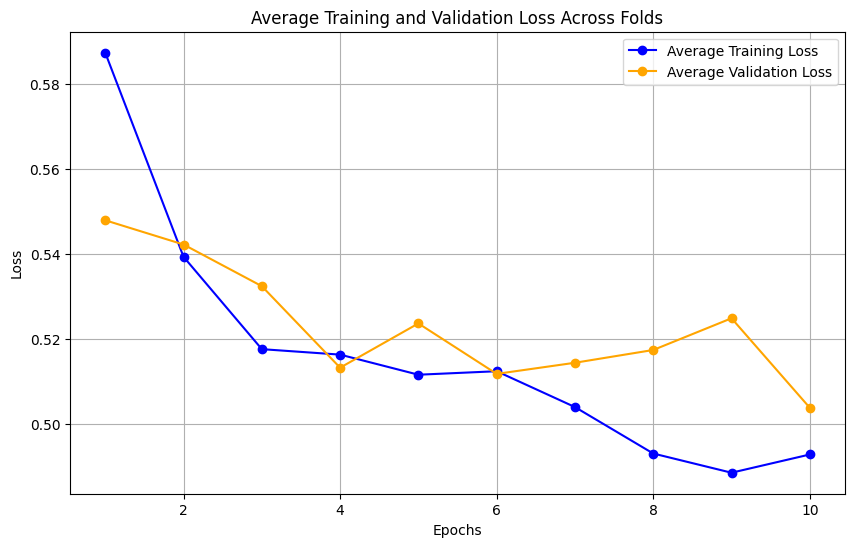

In [31]:
# DenseLayer or FinalClassifier
if isFinalClassifier:
    dense_layer_class = FinalClassifier
else:
    dense_layer_class = DenseLayer
    
output_dim = 768

# Run k-fold cross-validation   
results_df = cross_validate_model(
    dataset=full_dataset,
    model_class=SimultaneousParallel,
    dense_layer_class=dense_layer_class,
    criterion=criterion,
    output_dim=output_dim,
    num_epochs=num_epochs_cv,    
    num_folds=num_folds,
    train_batch_size=train_batch_size,
    val_batch_size=val_batch_size,
    learning_rate=learning_rate,
    output_file=f'results/simulParallel/SimulParallel-CV_scores.csv'
)

In [32]:
df = pd.read_csv(f'results/simulParallel/SimulParallel-CV_scores.csv')
df

,Metrics,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
0,Loss,0.535353,0.499396,0.464720,0.508549,0.511043,0.503812
1,Accuracy,0.766038,0.781132,0.788679,0.769811,0.773585,0.775849
2,Precision,0.684211,0.571429,0.794118,0.517241,0.588235,0.631047
3,Recall,0.188406,0.375000,0.355263,0.241935,0.158730,0.263867
4,F1 Score,0.295455,0.452830,0.490909,0.329670,0.250000,0.363773
